# Feature importance

The data processing operations for the bureau data in `06-Feature engineering 2.ipynb` were made into functions. 

Using these we used Random Search over the parameter space for LGBM to find an optimal model (saved as `lgbm_random.pickle`). This model did the best so far on the Kaggle test set (0.75373 private, 0.75257 public).

In this notebook we explore feature importance and the extent of overfitting.

## Set-up

In [1]:
import pickle
import os

import pandas as pd
import numpy as np
import shap
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('..')

In [3]:
from src.models.lgbm import load_datasets

In [4]:
pd.options.display.max_columns = None

## Load model

In [5]:
RANDOM_SEED=42

In [6]:
%%time
train, dev, test, test_kaggle = load_datasets(random_seed=RANDOM_SEED)

CPU times: user 38.9 s, sys: 15.8 s, total: 54.7 s
Wall time: 56.2 s


In [7]:
X_train = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train = train['TARGET']
X_dev = dev.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_dev = dev['TARGET']

In [8]:
X_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THUR

In [9]:
lgbm_random = pickle.load(open('lgbm_random.pickle', 'rb'))

In [10]:
# Train ROCAUC
roc_auc_score(y_train, lgbm_random.predict_proba(X_train)[:,1])

0.8251366880975682

In [11]:
# Dev ROCAUC
roc_auc_score(y_dev, lgbm_random.predict_proba(X_dev)[:,1])

0.7602774343456026

Still very large difference between training and dev. __To what extent is this due to the number of features?__

## Feature reduction

We created a function which starts with the LGBM model above and finds the ranking of feature importances. The bottom 20% are dropped and a new LGBM model is trained.

The process is repeated for a specified number of rounds and the train and dev ROC AUCs are reported.

We see if the delta between train and dev ROC AUC falls as we reduce the number of features. We also see how much the dev ROC AUC falls as we reduce the number of features.

In [12]:
from src.models.utils import lgbm_feature_reduction

In [13]:
output = lgbm_feature_reduction(
    lgbm_random.best_estimator_,
    X_train,
    y_train,
    X_dev,
    y_dev,
    18,
    lgbm_random.best_params_
)

2020-05-14 01:00:49,064 - Initial model: Training ROC AUC: 0.8251366880975682, Dev ROC AUC: 0.7602774343456026
2020-05-14 01:00:49,065 - Round 1 of feature dropping:

2020-05-14 01:00:49,094 - Number of features with importance below cutoff: 229
2020-05-14 01:00:59,027 - After 1 of dropping features: Training ROC AUC: 0.8251366880975682, Dev ROC AUC: 0.7602774343456026

2020-05-14 01:00:59,028 - Round 2 of feature dropping:

2020-05-14 01:00:59,048 - Number of features with importance below cutoff: 51
2020-05-14 01:01:07,803 - After 2 of dropping features: Training ROC AUC: 0.8243850475686763, Dev ROC AUC: 0.7594425920093335

2020-05-14 01:01:07,804 - Round 3 of feature dropping:

2020-05-14 01:01:07,820 - Number of features with importance below cutoff: 37
2020-05-14 01:01:15,260 - After 3 of dropping features: Training ROC AUC: 0.8242987129468826, Dev ROC AUC: 0.7575416144196215

2020-05-14 01:01:15,260 - Round 4 of feature dropping:

2020-05-14 01:01:15,274 - Number of features with

(0.5, 1.0)

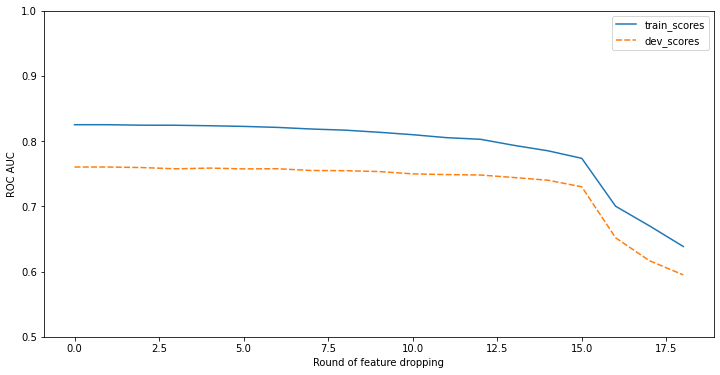

In [14]:
score_df = pd.DataFrame(
    {
        'train_scores': output['train_scores'],
        'dev_scores': output['dev_scores']
    }
)

plt.figure(figsize=(12,6))
plt.ylabel('ROC AUC')
plt.xlabel('Round of feature dropping')
sns.lineplot(data=score_df)

plt.ylim((0.5, 1))

In [15]:
lgbm_10 = output['models'][10]

In [16]:
features_10 = output['features_after_round'][10]
len(features_10)

25

In [17]:
X_train.shape

(184506, 450)

In [18]:
lgbm_10.predict_proba(X_train[features_10])[:,1]

array([0.02493168, 0.11269732, 0.01540587, ..., 0.04482359, 0.16182918,
       0.09089732])

__Conclusions__

Reducing the feature set from 450 to 25 only leads to a reduction in dev ROC AUC of 0.01. However, from the graph above we can see that the delta between train and dev doesn't fall significantly as we drop more features. This suggests that the model may benefit from further regularisation. It may also be worth doing a few rounds of feature dropping as well.

## SHAP plots

How much do the most important features change after feature dropping?

In [20]:
explainer = shap.TreeExplainer(lgbm_10)
shap_values = explainer.shap_values(X_train[features_10])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


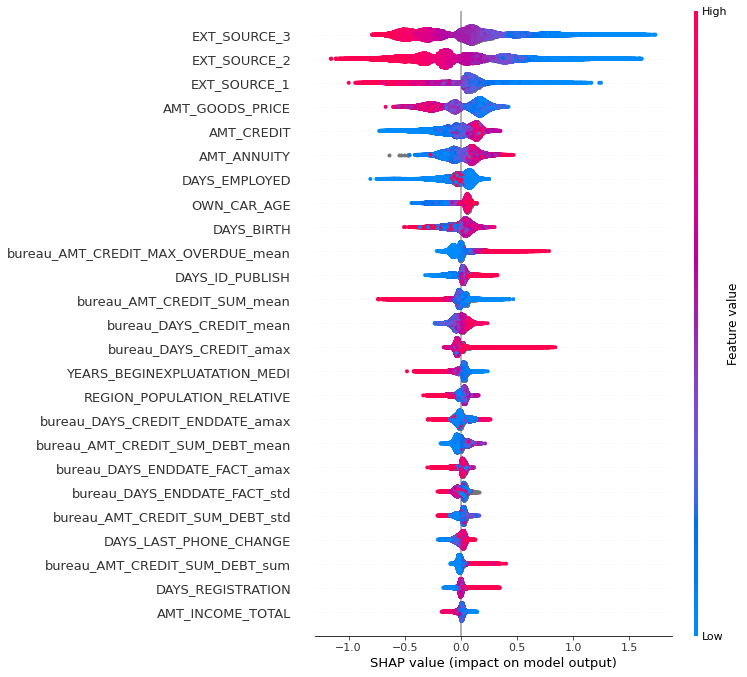

In [21]:
shap.summary_plot(shap_values[1], X_train[features_10], max_display=25)

### SHAP for original model

In [22]:
explainer = shap.TreeExplainer(lgbm_random.best_estimator_)
shap_values = explainer.shap_values(X_train)

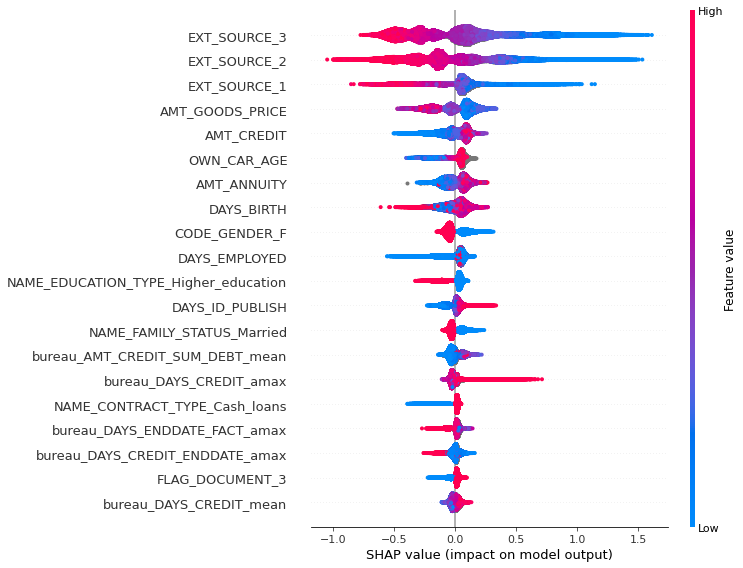

In [23]:
shap.summary_plot(shap_values[1], X_train)

Some re-shuffling of features but top 3 are the same. Data in bureau_balance not important in either model, possibly due to number of nulls.